In [91]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

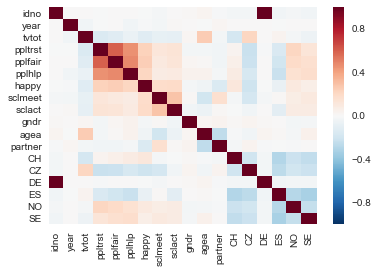

In [92]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Make the categorical variable 'country' into dummies.
df2 = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)

df2.head(10)

sns.heatmap(df2.corr())

In [93]:
y = df2['partner'] - 1
X = df2.loc[:, ~df2.columns.isin(['partner', 'cntry', 'idno'])]


# Create training and test sets through random selection.
msk = np.random.rand(len(df2)) < 0.8
train_data = df2[msk]
test_data = df2[~msk]


# Define outcome and predictors.
# Set our outcome to 0 and 1.
y_train = train_data['partner'] - 1
X_train = train_data.loc[:, ~train_data.columns.isin(['partner', 'cntry', 'idno'])]
y_test = test_data['partner'] - 1
X_test = test_data.loc[:, ~test_data.columns.isin(['partner', 'cntry', 'idno'])]


In [94]:
"""
Modifications include:
Creating new features *** Can be done through manually creating features or PCA
Applying more overfitting-prevention strategies like subsampling *** Subsample is a parameter
More iterations *** Parameter n_estimators
Trying a different loss function *** Options are 'exponential' and 'deviance'
Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications"""

"\nModifications include:\nCreating new features *** Can be done through manually creating features or PCA\nApplying more overfitting-prevention strategies like subsampling *** Subsample is a parameter\nMore iterations *** Parameter n_estimators\nTrying a different loss function *** Options are 'exponential' and 'deviance'\nChanging the structure of the weak learner: Allowing more leaves in the tree, or other modifications"

In [95]:
pca = PCA(n_components=5)
X_std_pca = pca.fit_transform(X_train)
X1 = pd.DataFrame(X_std_pca)

pca = PCA(n_components=5)
X_std_pca = pca.fit_transform(X_test)
X2 = pd.DataFrame(X_std_pca)

In [96]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf.fit(X1, y_train)

predict_train = clf.predict(X1)
predict_test = clf.predict(X2)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0006137793463249962
Percent Type II errors: 0.007518796992481203

Test set accuracy:
Percent Type I errors: 0.09570552147239264
Percent Type II errors: 0.1901840490797546


In [97]:
lr = LogisticRegression(C=1, penalty='l1')
rfe = RFE(lr,n_features_to_select=8) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))

   Features  Ranking  Support
0      year        1     True
5     happy        1     True
6   sclmeet        1     True
8      gndr        1     True
9      agea        1     True
10       CH        1     True
11       CZ        1     True
15       SE        1     True
4    pplhlp        2    False
2   ppltrst        3    False
1     tvtot        4    False
7    sclact        5    False
3   pplfair        6    False
14       NO        7    False
13       ES        8    False
12       DE        9    False


In [98]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=1000, subsample=0.75, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0006137793463249962
Percent Type II errors: 0.005677458953506215

Test set accuracy:
Percent Type I errors: 0.1116564417177914
Percent Type II errors: 0.1687116564417178


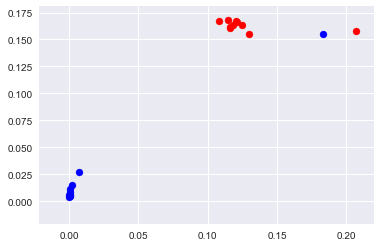

[[0.1, 0.36503067484662577], [0.2, 0.28527607361963192], [0.30000000000000004, 0.28773006134969326], [0.4, 0.27668711656441713], [0.5, 0.28711656441717792], [0.6, 0.28773006134969326], [0.7, 0.2822085889570552], [0.7999999999999999, 0.27546012269938652], [0.8999999999999999, 0.27791411042944786], [0.9999999999999999, 0.28282208588957058]]


In [99]:
g = 0.1
a = []
b = []
c = []
d = []
e = []
while g < 1.00001:
    clf = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=1000, subsample=g, 
                                              criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                              verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    a.append(train_tI_errors)
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
    b.append(train_tII_errors)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    c.append(test_tI_errors)
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    d.append(test_tII_errors)
    f = test_tI_errors + test_tII_errors
    e.append([g, f])
    g += 0.1

plt.scatter(a, b, color='b')
plt.scatter(c, d, color='r')

plt.show()
print(e)

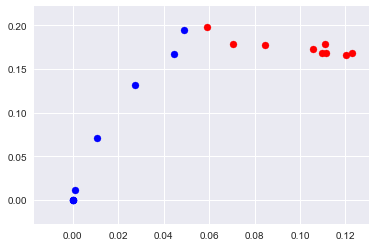

[[1, 0.25644171779141106], [2, 0.249079754601227], [3, 0.2625766871165644], [4, 0.27852760736196319], [5, 0.28588957055214725], [6, 0.29141104294478526], [7, 0.27852760736196319], [8, 0.28036809815950919], [9, 0.28957055214723926]]


In [100]:
g = 1
a = []
b = []
c = []
d = []
e = []

while g < 10:
    clf = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=1000, subsample=1.0, 
                                              criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_depth=g, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                              verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    a.append(train_tI_errors)
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
    b.append(train_tII_errors)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    c.append(test_tI_errors)
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    d.append(test_tII_errors)
    f = test_tI_errors + test_tII_errors
    e.append([g, f])
    g += 1

plt.scatter(a, b, color='b')
plt.scatter(c, d, color='r')

plt.show()
print(e) 

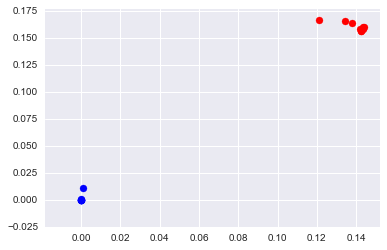

[[1000, 0.28711656441717792], [2000, 0.29938650306748466], [3000, 0.30122699386503071], [4000, 0.30429447852760738], [5000, 0.30184049079754605], [6000, 0.29877300613496938], [7000, 0.30306748466257671], [8000, 0.29877300613496938], [9000, 0.29999999999999999], [10000, 0.30061349693251538]]


In [101]:
g = 1000
a = []
b = []
c = []
d = []
e = []

while g < 10001:
    clf = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=g, subsample=1.0, 
                                              criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                              verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    a.append(train_tI_errors)
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
    b.append(train_tII_errors)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    c.append(test_tI_errors)
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    d.append(test_tII_errors)
    f = test_tI_errors + test_tII_errors
    e.append([g, f])
    g += 1000

plt.scatter(a, b, color='b')
plt.scatter(c, d, color='r')

plt.show()
print(e) 

In [102]:
#Optimal seems to be:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=500, subsample=0.6, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=2, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


SyntaxError: invalid syntax (<ipython-input-102-247883ec9378>, line 3)

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()